In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
     pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import cv2
import numpy as np
from PIL import Image, ImageEnhance
from torchvision import transforms
from tqdm import 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model




In [2]:

train_df = pd.read_csv("/kaggle/input/sports-image-classification/dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/sports-image-classification/dataset/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

print(train_df.head())


Train shape: (8227, 2)
Test shape: (2056, 1)
         image_ID      label
0  7c225f7b61.jpg  Badminton
1         b31.jpg  Badminton
2  acb146546c.jpg  Badminton
3  0e62f4d8f2.jpg  Badminton
4  cfd2c28c74.jpg    Cricket


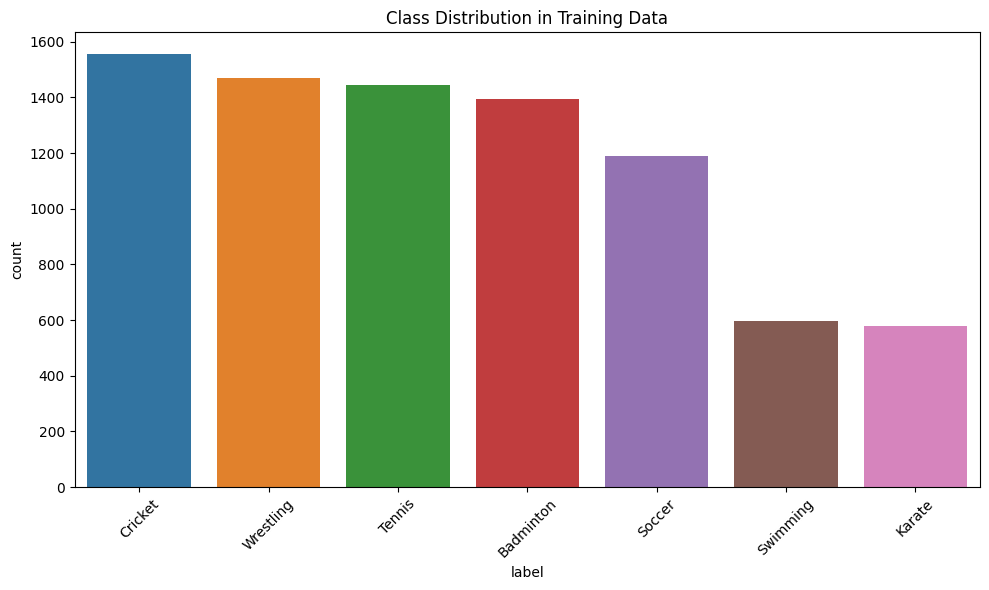

In [3]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='label', order=train_df['label'].value_counts().index)
plt.title("Class Distribution in Training Data")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


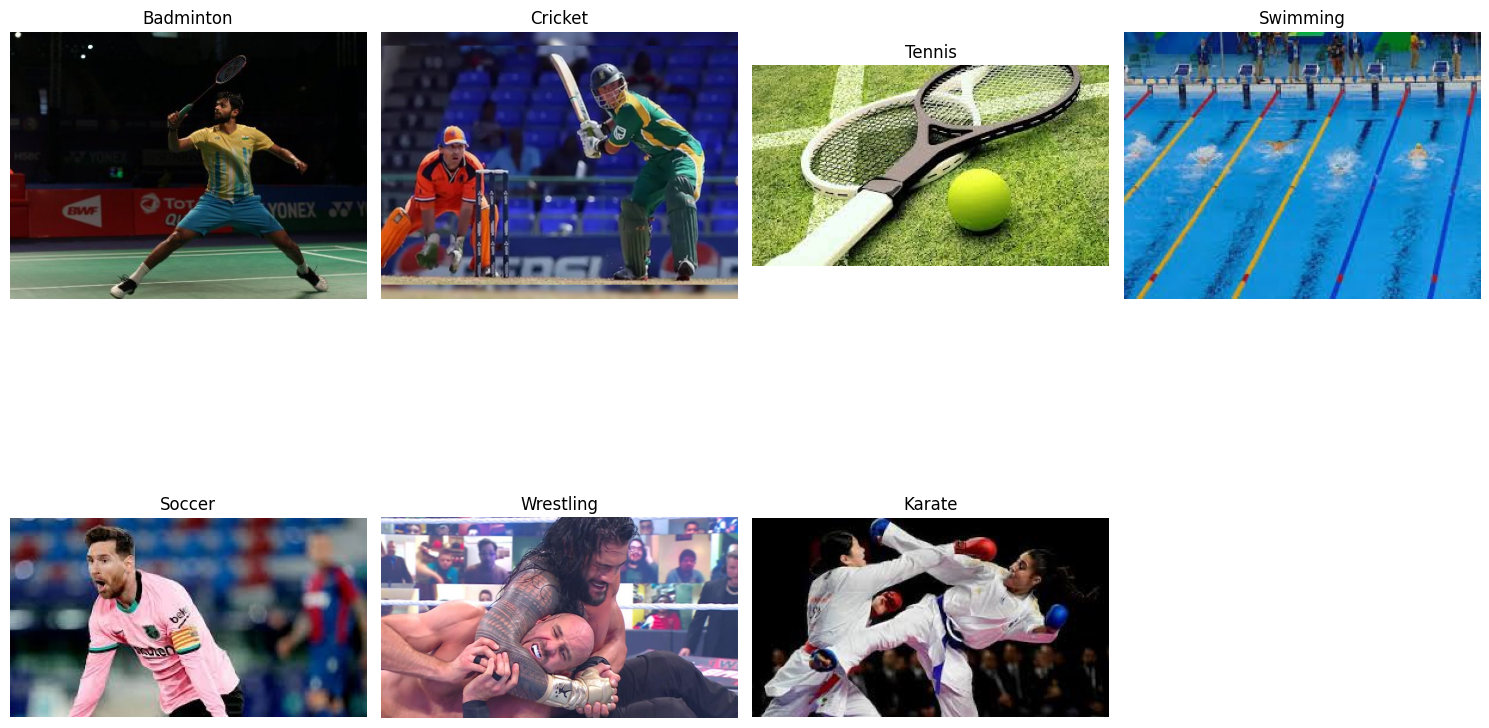

In [4]:

IMG_DIR = "/kaggle/input/sports-image-classification/dataset/train"
classes = train_df['label'].unique()
plt.figure(figsize=(15, 10))

for i, cls in enumerate(classes):
    # Get one image from each class
    sample_img_id = train_df[train_df['label'] == cls]['image_ID'].iloc[0]
    img_path = os.path.join(IMG_DIR, sample_img_id)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Duplicates in image_id
duplicate_ids = train_df[train_df.duplicated("image_ID")]
print("Duplicate image_id entries:")
print(duplicate_ids)

# Remove duplicates if needed
train_df.drop_duplicates(subset="image_ID", inplace=True)
train_df.reset_index(drop=True, inplace=True)


Duplicate image_id entries:
Empty DataFrame
Columns: [image_ID, label]
Index: []


Found 2 exact duplicate image pairs.


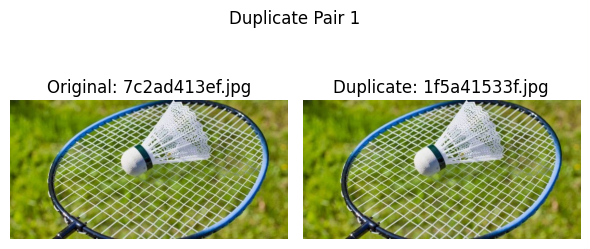

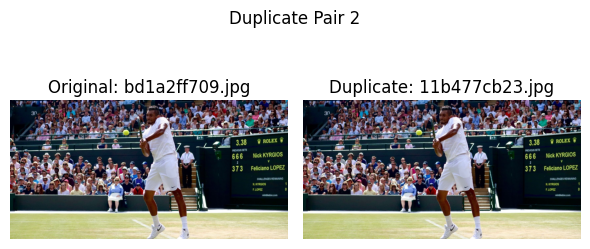

In [6]:

def get_image_hash(image_path):
    with open(image_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

image_hashes = {}
duplicate_image_pairs = []  # Store (original, duplicate) pairs

for i, row in train_df.iterrows():
    img_path = IMG_DIR + '/' + row['image_ID']
    try:
        img_hash = get_image_hash(img_path)
        if img_hash in image_hashes:
            duplicate_image_pairs.append((image_hashes[img_hash], row['image_ID']))
        else:
            image_hashes[img_hash] = row['image_ID']
    except:
        continue

print(f"Found {len(duplicate_image_pairs)} exact duplicate image pairs.")

# 🔍 Plot first few duplicate pairs
num_to_show = min(5, len(duplicate_image_pairs))
for i in range(num_to_show):
    img1_id, img2_id = duplicate_image_pairs[i]
    img1 = cv2.imread(IMG_DIR + '/' + img1_id)
    img2 = cv2.imread(IMG_DIR + '/' + img2_id)

    # Convert from BGR to RGB for matplotlib
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6,3))
    plt.suptitle(f'Duplicate Pair {i+1}')
    
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(f'Original: {img1_id}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(f'Duplicate: {img2_id}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [7]:
# Step 1: Extract duplicate image IDs only (second in each pair)
duplicate_ids_to_remove = [dup for orig, dup in duplicate_image_pairs]

# Step 2: Remove them from the DataFrame
print(f"Removing {len(duplicate_ids_to_remove)} duplicate entries...")

train_df_cleaned = train_df[~train_df['image_ID'].isin(duplicate_ids_to_remove)].copy()
train_df_cleaned.reset_index(drop=True, inplace=True)

print(f"Dataset reduced from {len(train_df)} to {len(train_df_cleaned)} images.")

train_df_cleaned.to_csv("train_cleaned.csv", index=False)



Removing 2 duplicate entries...
Dataset reduced from 8227 to 8225 images.


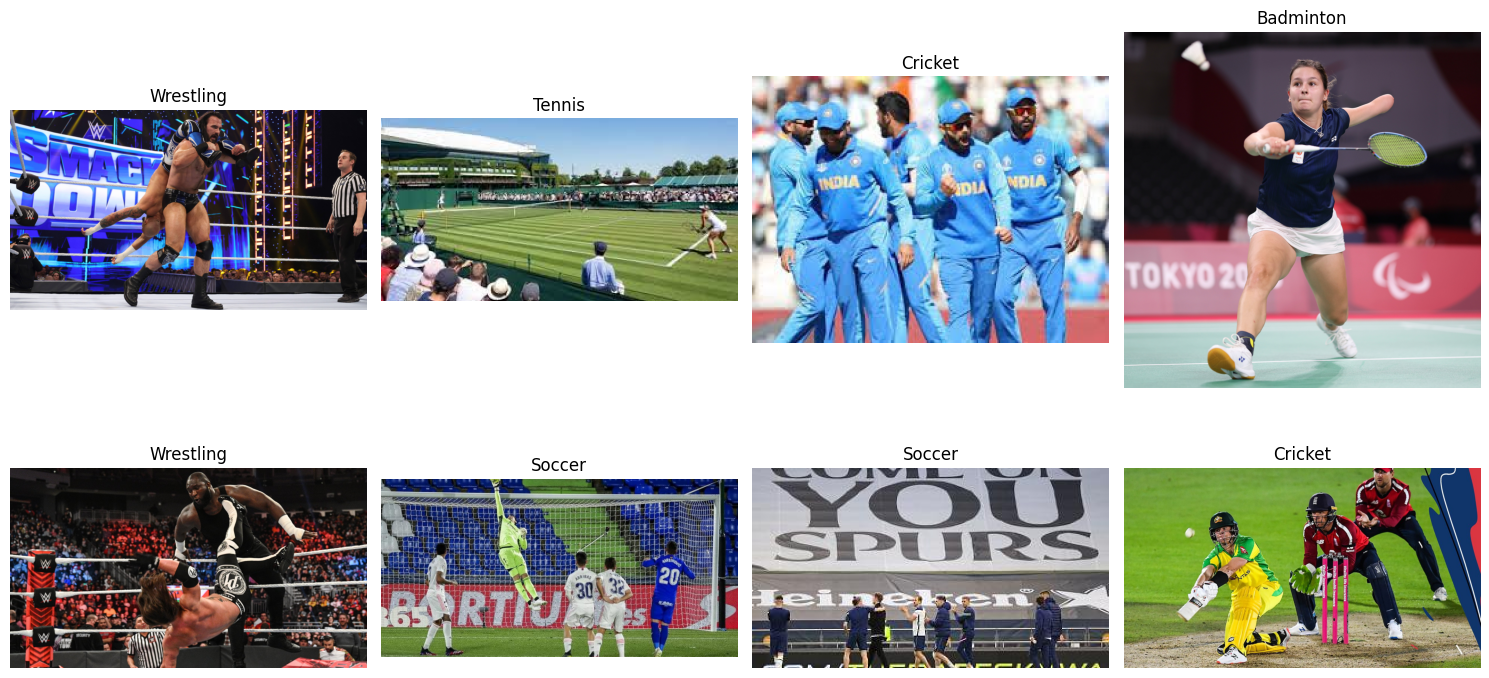

In [9]:

sample_rows = train_df.sample(8)
plt.figure(figsize=(15, 8))

for i, (_, row) in enumerate(sample_rows.iterrows()):
    img_path = os.path.join(IMG_DIR, row['image_ID'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(row['label'])
    plt.axis('off')

plt.tight_layout()
plt.show()


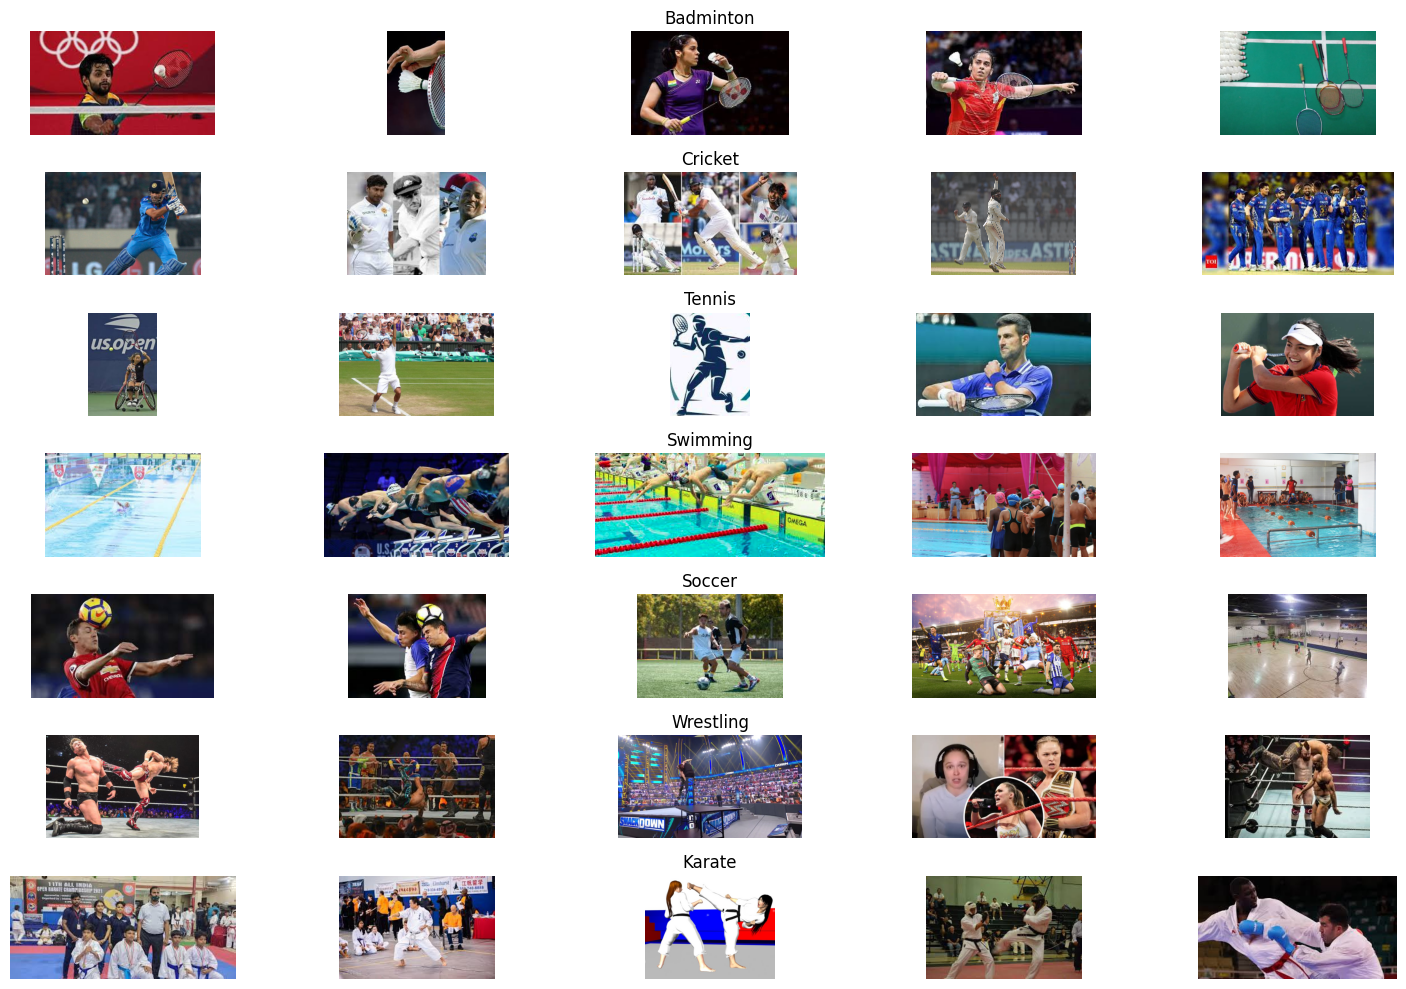

In [10]:

classes = train_df['label'].unique()
plt.figure(figsize=(15, 10))

for i, cls in enumerate(classes):
    sample_imgs = train_df[train_df['label'] == cls].sample(5)['image_ID'].values
    for j, img_id in enumerate(sample_imgs):
        img_path = os.path.join(IMG_DIR, img_id)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(classes), 5, i*5 + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if j == 2:
            plt.title(cls)

plt.tight_layout()
plt.show()


100%|██████████| 8227/8227 [00:30<00:00, 270.39it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


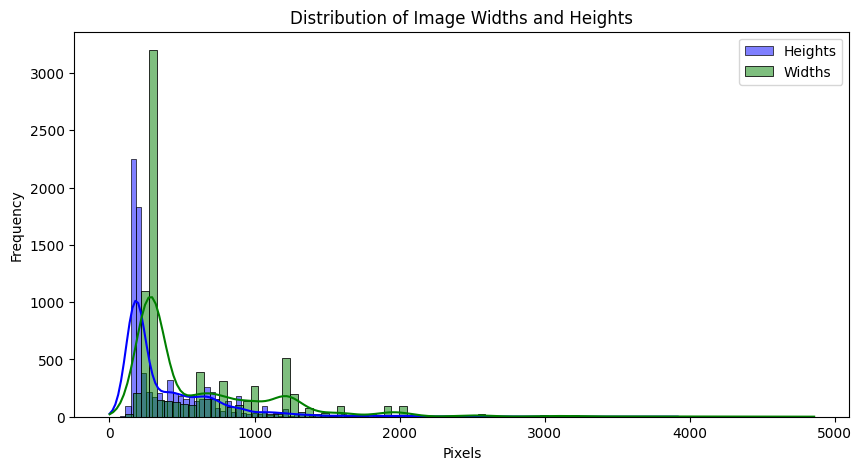

In [11]:
from tqdm import tqdm

widths = []
heights = []

for img_id in tqdm(train_df['image_ID']):
    img_path = os.path.join(IMG_DIR, img_id)
    img = cv2.imread(img_path)
    if img is not None:
        h, w = img.shape[:2]
        heights.append(h)
        widths.append(w)

plt.figure(figsize=(10,5))
sns.histplot(heights, kde=True, color='blue', label='Heights')
sns.histplot(widths, kde=True, color='green', label='Widths')
plt.legend()
plt.title("Distribution of Image Widths and Heights")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.show()


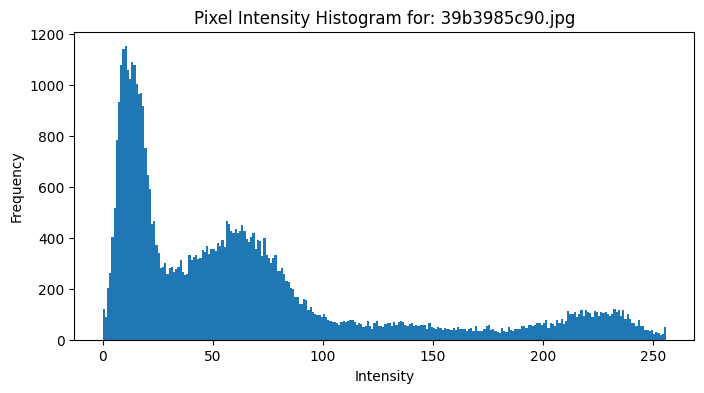

In [12]:
sample_img_id = train_df.sample(1)['image_ID'].values[0]
gray = cv2.imread(IMG_DIR+ '/'+ sample_img_id, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8, 4))
plt.hist(gray.ravel(), bins=256, range=[0, 256])
plt.title(f"Pixel Intensity Histogram for: {sample_img_id}")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()


Generating augmented images...


100%|██████████| 8225/8225 [02:30<00:00, 54.73it/s]


Original dataset: 8225, After augmentation: 16450


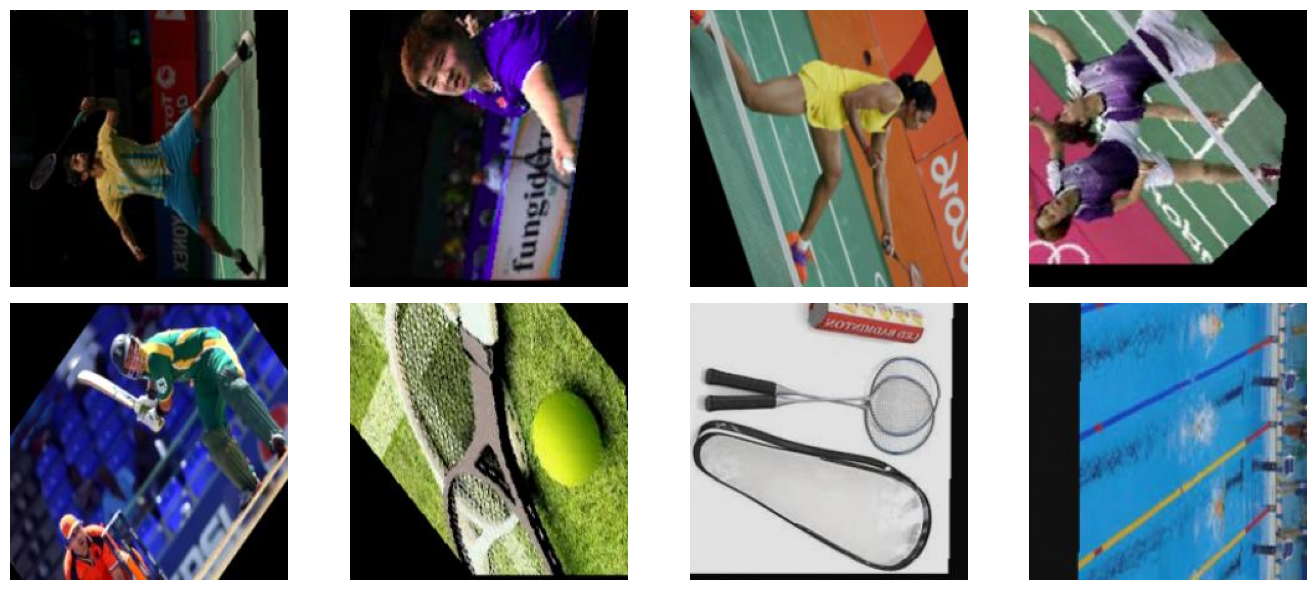

In [13]:

# Set seed for reproducibility
random.seed(42)
np.random.seed(42)

# Paths
ORIG_IMG_DIR = "/kaggle/input/sports-image-classification/dataset/train"
AUG_IMG_DIR = "/kaggle/working/augmented_images"
os.makedirs(AUG_IMG_DIR, exist_ok=True)

# Label mapping
label_to_idx = {label: idx for idx, label in enumerate(train_df_cleaned['label'].unique())}

# Custom noise function
def add_noise(image, noise_factor=0.1):
    image = np.array(image)
    noise = np.random.normal(0, noise_factor, image.shape)
    noisy_image = np.clip(image + noise, 0, 255)
    return Image.fromarray(noisy_image.astype(np.uint8))

# Data augmentation pipeline
augment_transform = transforms.Compose([
    # Rotation: Randomly rotate the image by 90 or 180 degrees
    transforms.Lambda(lambda x: x.rotate(random.choice([90, 45,65,180]))),
    
    # Translation: Randomly shift the image horizontally or vertically (10%)
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    
    # Scaling: Random crop with scale between 80% to 130%
    transforms.RandomResizedCrop(224, scale=(0.8, 1.3)),
    
    # Flipping: Horizontal and vertical flips
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    
    # Shearing: Apply affine shear of up to 10 degrees
    transforms.RandomAffine(0, shear=10),
    
    # Zooming: Adjust crop scale between 70% to 100%
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    
    # Brightness and contrast adjustment
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    
    # Add Gaussian noise
    transforms.Lambda(lambda x: add_noise(x, noise_factor=0.1)),
])

# Create augmented images and DataFrame
augmented_data = []

print("Generating augmented images...")
for i, row in tqdm(train_df_cleaned.iterrows(), total=len(train_df_cleaned)):
    orig_path = os.path.join(ORIG_IMG_DIR, row['image_ID'])
    try:
        image = Image.open(orig_path).convert('RGB')
        for j in range(1):  # Generate 1 augmentation per image (change to more if needed)
            aug_image = augment_transform(image)
            aug_filename = f"aug_{i}_{j}.jpg"
            aug_path = os.path.join(AUG_IMG_DIR, aug_filename)
            aug_image.save(aug_path)

            augmented_data.append({
                'image_ID': aug_filename,
                'label': row['label']
            })
    except:
        continue

# Create a DataFrame from the augmented images
augmented_df = pd.DataFrame(augmented_data)

# Combine with original data
combined_df = pd.concat([train_df_cleaned, augmented_df], ignore_index=True)
print(f"Original dataset: {len(train_df_cleaned)}, After augmentation: {len(combined_df)}")

# You can save this combined dataframe if needed
combined_df.to_csv("train_with_augmented.csv", index=False)

# Update IMG_DIR to point to combined original + augmented image folder
# We'll use both folders by pointing to a merged folder structure
FINAL_IMG_DIR = "/kaggle/working/combined_images"
os.makedirs(FINAL_IMG_DIR, exist_ok=True)

# Copy original images to combined folder (symbolic for Kaggle runtime)
for i, row in train_df_cleaned.iterrows():
    src = os.path.join(ORIG_IMG_DIR, row['image_ID'])
    dst = os.path.join(FINAL_IMG_DIR, row['image_ID'])
    if not os.path.exists(dst):
        os.system(f"cp '{src}' '{dst}'")

# Move augmented images
for i, row in augmented_df.iterrows():
    src = os.path.join(AUG_IMG_DIR, row['image_ID'])
    dst = os.path.join(FINAL_IMG_DIR, row['image_ID'])
    if not os.path.exists(dst):
        os.system(f"cp '{src}' '{dst}'")

# Function to plot augmented images
def plot_augmented_images(img_paths, n_images=8):
    """ Display a batch of augmented images """
    plt.figure(figsize=(14, 6))
    for i in range(n_images):
        img_path = img_paths[i]
        image = Image.open(img_path)
        plt.subplot(2, 4, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot sample augmented images
augmented_img_paths = [os.path.join(AUG_IMG_DIR, row['image_ID']) for i, row in augmented_df.iterrows()]
plot_augmented_images(augmented_img_paths, n_images=8)


In [19]:

# First split into 80% train and 20% temp (val + test)
train_df, temp_df = train_test_split(
    combined_df, 
    test_size=0.2, 
    stratify=combined_df['label'], 
    random_state=42
)

# Split the 20% temp into 10% val and 10% test
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    stratify=temp_df['label'], 
    random_state=42
)

# Check sizes
print(f"Train set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")

# Optionally save them
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)


Train set: 13160
Validation set: 1645
Test set: 1645


In [ ]:
label_encoder = LabelEncoder()
all_labels = pd.concat([train_df['label'], val_df['label']])
label_encoder.fit(all_labels)


In [20]:

# Conv block with optional bottleneck and SE block
def conv_block(x, filters, kernel_size=3, strides=1, use_se=True):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same',
                      use_bias=False, kernel_regularizer=regularizers.l2(0.0005))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

    if use_se:
        # Squeeze-and-Excitation block
        se = layers.GlobalAveragePooling2D()(x)
        se = layers.Dense(filters // 8, activation='relu')(se)
        se = layers.Dense(filters, activation='sigmoid')(se)
        se = layers.Reshape((1, 1, filters))(se)
        x = layers.multiply([x, se])

    return x

2025-05-11 23:46:51.082301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747007211.267248      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747007211.321852      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [21]:
# model training

def train_model(
    train_df,
    val_df,
    final_img_dir,
    input_shape=(224, 224, 3),
    num_classes=7,
    batch_size=32,
    num_conv_blocks=6,
    dropout_rate=0.5,
    optimizer_name='adam',
    weight_decay=0.001,
    initial_lr=1e-4,
    lr_scheduler=True,
    epochs=30
):

    K.clear_session()

    # Dataset preparation
    def prepare_datasets(train_df, val_df, img_dir, img_size=(224, 224), batch_size=32):
        label_encoder = LabelEncoder()
        all_labels = pd.concat([train_df['label'], val_df['label']])
        label_encoder.fit(all_labels)

        train_df['encoded_label'] = label_encoder.transform(train_df['label'])
        val_df['encoded_label'] = label_encoder.transform(val_df['label'])

        def load_image(image_id, label):
            image_path = tf.strings.join([img_dir, image_id], separator=os.sep)
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, img_size)
            image = image / 255.0
            return image, label

        train_ds = tf.data.Dataset.from_tensor_slices((train_df['image_ID'].values, train_df['encoded_label'].values))
        val_ds = tf.data.Dataset.from_tensor_slices((val_df['image_ID'].values, val_df['encoded_label'].values))

        train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        return train_ds, val_ds
        
        # CNN architecture
    def variable_cnn(input_shape, num_classes, num_blocks, dropout_rate, weight_decay):
        inputs = tf.keras.Input(shape=input_shape)
        x = inputs
        filters = 32
        for _ in range(num_blocks):
            x = conv_block(x, filters, use_se=True)
            x = conv_block(x, filters, use_se=True)
            x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
            filters *= 2
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(512, activation='relu',
                                  kernel_regularizer=regularizers.l2(weight_decay))(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
        return tf.keras.Model(inputs, outputs)

    # Optimizer + LR scheduler
    def compile_model(model, optimizer_name, initial_lr, lr_scheduler):
        if optimizer_name == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
        elif optimizer_name == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate=initial_lr, momentum=0.9)
        elif optimizer_name == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=initial_lr)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer_name}")

        if lr_scheduler == 'exponential':
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_lr, decay_steps=1000, decay_rate=0.9, staircase=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        elif lr_scheduler == 'step':
            lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
                boundaries=[1000, 2000], values=[initial_lr, initial_lr * 0.5, initial_lr * 0.1])
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        elif lr_scheduler == 'cosine':
            lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
                initial_learning_rate=initial_lr, decay_steps=3000, alpha=0.1)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    # Training loop
    def train_and_evaluate(model, train_ds, val_ds, batch_size, epochs, weight_decay, lr_scheduler):
        callbacks = [
            ModelCheckpoint(filepath=f'/kaggle/working/best_model_one.keras',
                            monitor='val_loss', save_best_only=True, verbose=1),
            EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
        ]
        if lr_scheduler is True:
            callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_lr=1e-6))

        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )
        return history

    # Prepare data
    train_ds, val_ds = prepare_datasets(train_df, val_df, final_img_dir, img_size=input_shape[:2], batch_size=batch_size)

    # Handle multiple weight decays
    if isinstance(weight_decay, list):
        results = {}
        for wd in weight_decay:
            model = variable_cnn(input_shape, num_classes, num_conv_blocks, dropout_rate, wd)
            model = compile_model(model, optimizer_name, initial_lr, lr_scheduler)
            history = train_and_evaluate(model, train_ds, val_ds, batch_size, epochs, wd, lr_scheduler)
            results[wd] = history
        return results

    # Single weight decay
    model = variable_cnn(input_shape, num_classes, num_conv_blocks, dropout_rate, weight_decay)
    model = compile_model(model, optimizer_name, initial_lr, lr_scheduler)
    history = train_and_evaluate(model, train_ds, val_ds, batch_size, epochs, weight_decay, lr_scheduler)

    return model, history






In [23]:
results = {}

#3. Dropout Rate
for dropout_rate in [0.3, 0.5, 0.7]:
    print(f"\n🔧 Training with dropout_rate={dropout_rate}")
    model, history = train_model(
        train_df=train_df,
        val_df=val_df,
        final_img_dir=FINAL_IMG_DIR,
        dropout_rate=dropout_rate
    )
    model.save(f"/kaggle/working/model_dropout_{dropout_rate}.h5")
    results[f'dropout_rate_{dropout_rate}'] = history.history

# 4. Optimizer
for optimizer_name in ['sgd', 'adam', 'rmsprop']:
    print(f"\n🔧 Training with optimizer={optimizer_name}")
    model, history = train_model(
        train_df=train_df,
        val_df=val_df,
        final_img_dir=FINAL_IMG_DIR,
        optimizer_name=optimizer_name
    )
    model.save(f"/kaggle/working/model_optimizer_{optimizer_name}.h5")
    results[f'optimizer_{optimizer_name}'] = history.history



🔧 Training with dropout_rate=0.3


I0000 00:00:1747007222.935841      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30


I0000 00:00:1747007245.394472   32998 service.cc:148] XLA service 0x7f99e8016600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747007245.395070   32998 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747007247.269423   32998 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/412 ━━━━━━━━━━━━━━━━━━━━ 4:49:22 42s/step - accuracy: 0.0625 - loss: 4.4519

I0000 00:00:1747007266.741655   32998 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4989 - loss: 3.6676
Epoch 1: val_loss improved from inf to 3.71604, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 108s 161ms/step - accuracy: 0.4991 - loss: 3.6671 - val_accuracy: 0.4529 - val_loss: 3.7160 - learning_rate: 1.0000e-04
Epoch 2/30
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6399 - loss: 3.0952
Epoch 2: val_loss improved from 3.71604 to 2.94569, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.6399 - loss: 3.0950 - val_accuracy: 0.6565 - val_loss: 2.9457 - learning_rate: 1.0000e-04
Epoch 3/30
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6818 - loss: 2.7483
Epoch 3: val_loss improved from 2.94569 to 2.61044, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.6818 - loss: 2.7479 - val_accuracy: 0.6918 - val_loss: 2.6104 - learning_rate: 1.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.4740 - loss: 3.7526
Epoch 1: val_loss improved from inf to 3.88625, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 92s 148ms/step - accuracy: 0.4742 - loss: 3.7521 - val_accuracy: 0.2991 - val_loss: 3.8863 - learning_rate: 1.0000e-04
Epoch 2/30
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6322 - loss: 3.1840
Epoch 2: val_loss improved from 3.88625 to 3.32532, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.6323 - loss: 3.1835 - val_accuracy: 0.5459 - val_loss: 3.3253 - learning_rate: 1.0000e-04
Epoch 3/30
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6718 - loss: 2.8490
Epoch 3: val_loss improved from 3.32532 to 2.74582, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.6719 - loss: 2.8486 - val_accuracy: 0.6851 - val_loss: 2.7458 - learnin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.4615 - loss: 3.8226
Epoch 1: val_loss improved from inf to 4.36686, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 91s 147ms/step - accuracy: 0.4617 - loss: 3.8220 - val_accuracy: 0.2541 - val_loss: 4.3669 - learning_rate: 1.0000e-04
Epoch 2/30
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6227 - loss: 3.2552
Epoch 2: val_loss improved from 4.36686 to 3.18744, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.6227 - loss: 3.2549 - val_accuracy: 0.6128 - val_loss: 3.1874 - learning_rate: 1.0000e-04
Epoch 3/30
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6586 - loss: 2.9584
Epoch 3: val_loss improved from 3.18744 to 2.85438, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.6586 - loss: 2.9581 - val_accuracy: 0.6407 - val_loss: 2.8544 - learnin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/40
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3145 - loss: 4.1061
Epoch 1: val_loss improved from inf to 4.23159, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 76s 138ms/step - accuracy: 0.3147 - loss: 4.1056 - val_accuracy: 0.1884 - val_loss: 4.2316 - learning_rate: 1.0000e-04
Epoch 2/40
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5535 - loss: 3.5776
Epoch 2: val_loss improved from 4.23159 to 3.38407, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 46s 109ms/step - accuracy: 0.5537 - loss: 3.5773 - val_accuracy: 0.6310 - val_loss: 3.3841 - learning_rate: 1.0000e-04
Epoch 3/40
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6149 - loss: 3.4283
Epoch 3: val_loss improved from 3.38407 to 3.27692, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 46s 108ms/step - accuracy: 0.6150 - loss: 3.4282 - val_accuracy: 0.6742 - val_loss: 3.2769 - learnin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/40
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.4749 - loss: 3.7488
Epoch 1: val_loss improved from inf to 3.87123, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 92s 148ms/step - accuracy: 0.4751 - loss: 3.7483 - val_accuracy: 0.2906 - val_loss: 3.8712 - learning_rate: 1.0000e-04
Epoch 2/40
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6296 - loss: 3.1725
Epoch 2: val_loss improved from 3.87123 to 2.84348, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.6296 - loss: 3.1722 - val_accuracy: 0.6790 - val_loss: 2.8435 - learning_rate: 1.0000e-04
Epoch 3/40
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6722 - loss: 2.8387
Epoch 3: val_loss improved from 2.84348 to 2.71658, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.6723 - loss: 2.8384 - val_accuracy: 0.6711 - val_loss: 2.7166 - learnin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/40
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.4617 - loss: 3.7815
Epoch 1: val_loss improved from inf to 3.93952, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 81s 141ms/step - accuracy: 0.4619 - loss: 3.7810 - val_accuracy: 0.3021 - val_loss: 3.9395 - learning_rate: 1.0000e-04
Epoch 2/40
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6222 - loss: 3.1146
Epoch 2: val_loss improved from 3.93952 to 3.57151, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 46s 109ms/step - accuracy: 0.6223 - loss: 3.1140 - val_accuracy: 0.5131 - val_loss: 3.5715 - learning_rate: 1.0000e-04
Epoch 3/40
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6721 - loss: 2.7392
Epoch 3: val_loss improved from 3.57151 to 2.64210, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 46s 109ms/step - accuracy: 0.6721 - loss: 2.7388 - val_accuracy: 0.6626 - val_loss: 2.6421 - learnin

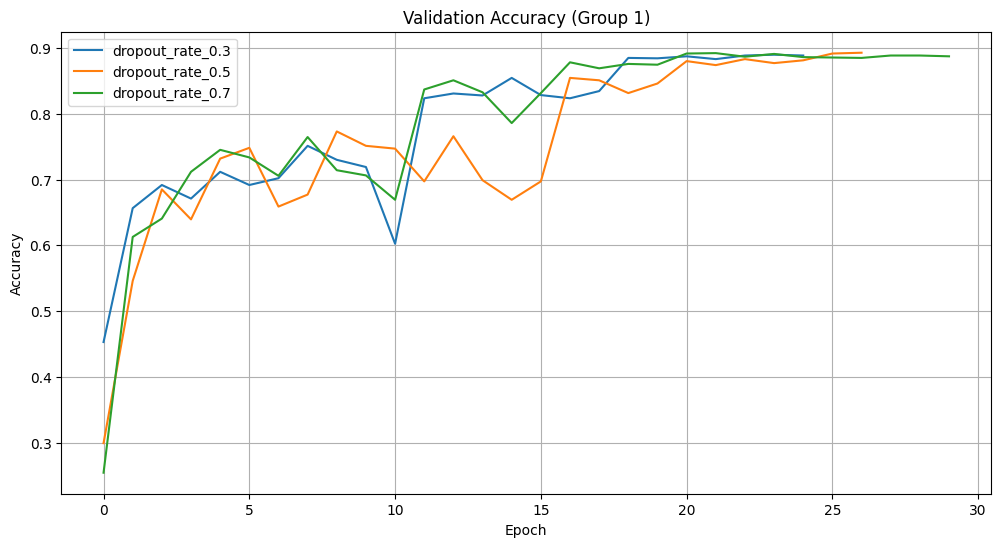

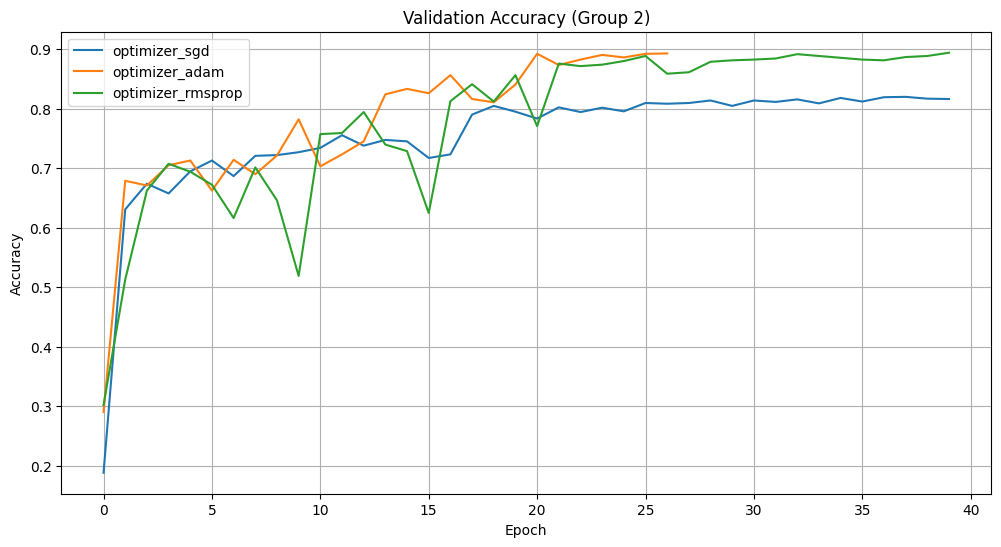

In [27]:
# Group every 3 experiments and plot each group separately
keys = list(results.keys())
group_size = 3

for i in range(0, len(keys), group_size):
    group_keys = keys[i:i + group_size]
    plt.figure(figsize=(12, 6))
    for key in group_keys:
        plt.plot(results[key]['val_accuracy'], label=key)
    
    plt.title(f'Validation Accuracy (Group {i // group_size + 1})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


In [29]:
# config summary

summary_data = []

for key, value in results.items():
    best_val_acc = max(value['val_accuracy'])
    summary_data.append({
        'Configuration': key,
        'Best Val Accuracy': round(best_val_acc, 4),
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(by='Best Val Accuracy', ascending=False).reset_index(drop=True)
print(summary_df)



       Configuration  Best Val Accuracy
0  optimizer_rmsprop             0.8942
1   dropout_rate_0.5             0.8930
2     optimizer_adam             0.8930
3   dropout_rate_0.7             0.8924
4   dropout_rate_0.3             0.8900
5      optimizer_sgd             0.8201


In [30]:

def prepare_test_dataset(test_df, img_dir, img_size=(224, 224), batch_size=32, label_encoder=None):
    if label_encoder is None:
        raise ValueError("You must pass the same LabelEncoder used in training.")

    test_df = test_df.copy()
    test_df['encoded_label'] = label_encoder.transform(test_df['label'])

    def load_image(image_id, label):
        image_path = tf.strings.join([img_dir, image_id], separator=os.sep)
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, img_size)
        image = image / 255.0
        return image, label

    test_ds = tf.data.Dataset.from_tensor_slices((test_df['image_ID'].values, test_df['encoded_label'].values))
    test_ds = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return test_ds

def model_evaluation(model, test_df, final_img_dir, input_shape, label_encoder, history=None, batch_size=32):
    # Prepare test dataset
    test_ds = prepare_test_dataset(
        test_df=test_df,
        img_dir=final_img_dir,
        img_size=input_shape[:2],
        batch_size=batch_size,
        label_encoder=label_encoder
    )

    # Evaluate model
    test_loss, test_acc = model.evaluate(test_ds, verbose=1)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Plot training/validation accuracy if history is provided
    if history:
        acc = history.history.get('accuracy')
        val_acc = history.history.get('val_accuracy')
        plt.plot(acc, label='Train Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()
    return test_acc


In [33]:

test_results = {}

# Evaluate models saved during dropout rate tuning
for dropout_rate in [0.3, 0.5, 0.7]:
    model_path = f"/kaggle/working/model_dropout_{dropout_rate}.h5"
    model = load_model(model_path)
    
    print(f"\n Evaluating model with dropout_rate={dropout_rate}")
    test_acc = model_evaluation(
        model=model,
        test_df=test_df,
        final_img_dir=FINAL_IMG_DIR,
        input_shape=(224, 224, 3),
        label_encoder=label_encoder,
        history=None  
    )
    test_results[f'dropout_rate_{dropout_rate}'] = test_acc

# Evaluate models saved during optimizer tuning
for optimizer_name in ['sgd', 'adam', 'rmsprop']:
    model_path = f"/kaggle/working/model_optimizer_{optimizer_name}.h5"
    model = load_model(model_path)

    print(f"\n Evaluating model with optimizer={optimizer_name}")
    test_acc = model_evaluation(
        model=model,
        test_df=test_df,
        final_img_dir=FINAL_IMG_DIR,
        input_shape=(224, 224, 3),
        label_encoder=label_encoder,
        history=None
    )
    test_results[f'optimizer_{optimizer_name}'] = test_acc



 Evaluating model with dropout_rate=0.3
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9019 - loss: 0.9573
Test Accuracy: 0.8948
Test Loss: 0.9912

 Evaluating model with dropout_rate=0.5
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8930 - loss: 0.9345
Test Accuracy: 0.8924
Test Loss: 0.9343

 Evaluating model with dropout_rate=0.7
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.8898 - loss: 1.0968
Test Accuracy: 0.8863
Test Loss: 1.1194

 Evaluating model with optimizer=sgd
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8398 - loss: 2.8104
Test Accuracy: 0.8292
Test Loss: 2.8116

 Evaluating model with optimizer=adam
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8955 - loss: 0.9568
Test Accuracy: 0.8906
Test Loss: 0.9645

 Evaluating model with optimizer=rmsprop
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8848 - loss: 1.0265
Test Accuracy: 0.8875
Test Loss: 1.0224
